# Neural Differential Equations

Reference: http://implicit-layers-tutorial.org/

In [195]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import random
from jax import lax
from jax import vmap
from jax.experimental.ode import odeint

from functools import partial
import matplotlib.pyplot as plt
from plotutil import PlotLayout


## JAX Basics

In [3]:
# 多个输入的话，要 pack 在一起
def f(x):
    return (x[0] * jnp.sin(x[1])).sum()
a = random.normal(key=random.PRNGKey(0), shape=[10])
b = random.normal(key=random.PRNGKey(1), shape=[10])
jax.grad(f)([a, b])

[DeviceArray([ 0.63715774, -0.46836656, -0.9151134 ,  0.12078889,
              -0.19473217, -0.4863231 ,  0.79298097,  0.99037117,
              -0.3592781 ,  0.14266834], dtype=float32),
 DeviceArray([-0.2867984 ,  0.23345721, -0.07359457, -0.731425  ,
              -0.4318749 , -0.13294047, -0.40901974,  0.08179767,
               0.68283427,  0.56149924], dtype=float32)]

In [217]:
x = jnp.ones((16, 32))
b3x = jnp.ones((3, 16, 32))
b24x = jnp.ones((24, 16, 32))

b24y = jnp.ones((24, 32))

def matmul(a, b):
    return jnp.dot(a, b)

print(x.shape, b24y.shape, "->", vmap(matmul, in_axes=(None, 0))(x, b24y).shape)
print(b3x.shape, b24y.shape, "->", vmap(matmul, in_axes=(None, 0))(b3x, b24y).shape)
print(b24x.shape, b24y.shape, "->", vmap(matmul, in_axes=(0, 0))(b24x, b24y).shape)
# ↓ 代码报错，vmap 的那些维度的长度必须一致
# print(b3x.shape, b24y.shape, "->", vmap(matmul, in_axes=(0, 0))(b3x, b24y).shape)

(16, 32) (24, 32) -> (24, 16)
(3, 16, 32) (24, 32) -> (24, 3, 16)
(24, 16, 32) (24, 32) -> (24, 16)


## JVP & VJP

**jvp**

$$
(x, v) \mapsto (f(x), \, \partial f(x) v)
$$

where $f : \mathbb R^n \to \mathbb R^m, x \in \mathbb R^n, v \in \mathbb R^n$

**vjp**

$$
(x, w) \mapsto (f(x), \, w^\mathsf{T} \partial f(x))
$$

where $w \in \mathbb R^m$


**比较**

- `JVP` 和 `VJP` 都要给定 `x` 返回 `y` 的。
- 从 signature 上看，`linearize` 更像 `vjp`，二者返回一个值和一个函数。`jvp` 是一个扰动已知的 `linearzie`

In [2]:
W = jax.random.normal(random.PRNGKey(1), shape=[2, 3])

def f(x):
    return jnp.sin(x) @ W

x = jax.random.normal(random.PRNGKey(2), shape=[1, 2])

dx = jnp.ones_like(x)
y, dy = jax.jvp(f, (x, ), (dx, ))
print("f(x) =", y, "dy = ", dy)

y, f_jvp = jax.linearize(f, x)
dy = f_jvp(dx)
print("f(x) =", y, "dy = ", dy)

dy = jnp.ones(shape=[1, 3])
y, f_vjp = jax.vjp(f, x)
print("f(x) =", y, "dx = ", f_vjp(dy))


f(x) = [[-0.5864568   0.95182043 -0.67893875]] dy =  [[ 0.7577558  -0.35786915  0.7260865 ]]
f(x) = [[-0.5864568   0.95182043 -0.67893875]] dy =  [[ 0.7577558  -0.35786915  0.7260865 ]]
f(x) = [[-0.5864568   0.95182043 -0.67893875]] dx =  (DeviceArray([[0.5005243, 0.6254488]], dtype=float32),)


## Implicit Layer

In [3]:
ndim = 10
W = random.normal(random.PRNGKey(0), (ndim, ndim)) / jnp.sqrt(ndim)
x = random.normal(random.PRNGKey(1), (ndim,))

""" solvers """
def fwd_solver(f, z_init):
    z_prev, z = z_init, f(z_init)
    while jnp.linalg.norm(z_prev - z) > 1e-5:
        z_prev, z = z, f(z)
    return z

def newton_solver(f, z_init):
    f_root = lambda z: f(z) - z
    g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z))
    return fwd_solver(g, z_init)

""" fix """
def fixed_point_layer(solver, f, params, x):
    z_star = solver(lambda z: f(params, x, z), z_init=jnp.zeros_like(x))
    return z_star

In [4]:
f = lambda W, x, z: jnp.tanh(jnp.dot(W, z) + x)
z1 = fixed_point_layer(fwd_solver, f, W, x)
z2 = fixed_point_layer(newton_solver, f, W, x)
print("z diff = ", (z1 - z2).sum())

g1 = jax.grad(lambda W: fixed_point_layer(fwd_solver, f, W, x).sum())(W)
g2 = jax.grad(lambda W: fixed_point_layer(newton_solver, f, W, x).sum())(W)
print("grad diff = ", (g1 - g2).sum())

z diff =  -1.475215e-06
grad diff =  -1.0520162e-06


In [5]:

@partial(jax.custom_vjp, nondiff_argnums=(0, 1))
def fixed_point_layer_2(solver, f, params, x):
    z_star = solver(lambda z: f(params, x, z), z_init=jnp.zeros_like(x))
    return z_star

def fixed_point_layer_2_fwd(solver, f, params, x):
    z_star = fixed_point_layer_2(solver, f, params, x)
    return z_star, (params, x, z_star)

def fixed_point_layer_2_bwd(solver, f, res, z_star_bar):
    params, x, z_star = res
    _, vjp_a = jax.vjp(lambda params, x: f(params, x, z_star), params, x)
    _, vjp_z = jax.vjp(lambda z: f(params, x, z), z_star)
    return vjp_a(
        solver(lambda u: vjp_z(u)[0] + z_star_bar, z_init=jnp.zeros_like(z_star))
    )

fixed_point_layer_2.defvjp(fixed_point_layer_2_fwd, fixed_point_layer_2_bwd)


In [6]:
g1 = jax.grad(lambda W: fixed_point_layer(newton_solver, f, W, x).sum())(W)
g2 = jax.grad(lambda W: fixed_point_layer_2(newton_solver, f, W, x).sum())(W)
print("grad diff = ", (g1 - g2).sum())

grad diff =  -4.6769856e-08


## ODE

$$
f'(t) = \mathrm{some\_function}(x, y, z) \\
\\ 

\mathrm{i.e.} \left\{ \begin{array}{ll}
x'(t) & = \sigma (y - x) \\
y'(t) & = x (\rho - z) - y \\
z'(t) & = x y - \beta z \\
\end{array} \right. \\
\mathrm{s.t.~~}f(0)=(x_0, y_0, z_0)
$$

注意这里的变化量是 $x, y, z$ 三个 $\mathbb{R}$，而不是一个 $\mathbb{R}^3$ 的空间。

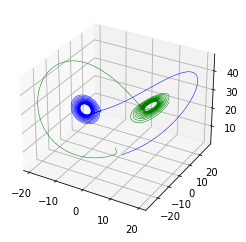

In [33]:
def plot_3d_path(ax, ys, color):
    x0, x1, x2 = ys.T
    ax.plot(x0, x1, x2, lw=0.5, color=color)


def f(state, t, rho, sigma, beta):
    x, y, z = state
    return jnp.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])


def odeint_euler(f, y0, t, *args):
    def step(state, t):
        y_prev, t_prev = state
        dt = t - t_prev
        y = y_prev + dt * f(y_prev, t_prev, *args)
        return (y, t), y

    _, ys = lax.scan(step, (y0, t[0]), t[1:])
    return ys


ys_jax = odeint(
    partial(f, rho=28., sigma=10., beta=8. / 3),  #
    y0=jnp.array([1., 1., 1.]),
    t=jnp.linspace(0, 10., 10000))

ys_euler = odeint_euler(
    partial(f, rho=28., sigma=10., beta=8. / 3),  #
    y0=jnp.array([-2., 2., 3.]),  #
    t=jnp.linspace(0, 10., 100000))

ax = plt.subplot(projection="3d")
plot_3d_path(ax, ys_jax, 'b')
plot_3d_path(ax, ys_euler, 'g')

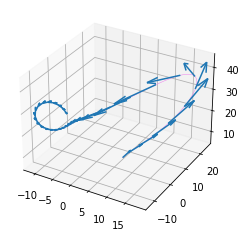

In [37]:
odeint_euler_2 = jax.custom_jvp(odeint_euler, nondiff_argnums=(0, ))


@odeint_euler_2.defjvp
def odeint_euler_jvp(f, primals, tangents):
    y0, t, *args = primals
    delta_y0, _, *delta_args = tangents
    nargs = len(args)

    def f_aug(aug_state, t, *args_and_delta_args):
        primal_state, tangent_state = aug_state
        args, delta_args = args_and_delta_args[:nargs], args_and_delta_args[nargs:]
        primal_dot, tangent_dot = jax.jvp(f, (primal_state, t, *args), (tangent_state, 0., *delta_args))
        return jnp.stack([primal_dot, tangent_dot])

    aug_init_state = jnp.stack([y0, delta_y0])
    aug_states = odeint_euler_2(f_aug, aug_init_state, t, *args, *delta_args)
    ys, ys_dot = aug_states[:, 0, :], aug_states[:, 1, :]
    return ys, ys_dot


def evolve(y0):
    return odeint_euler_2(f, y0, jnp.linspace(0, 1., 1000), 28., 10., 8. / 3)


y0 = jnp.array([5., 5., 5.])
delta_y0 = jnp.array([0., 5., 0.])
ys, delta_ys = jax.jvp(evolve, (y0, ), (delta_y0, ))


def plot_3d_path_with_delta(ax, ys, delta_ys, color):
    x0, x1, x2 = ys.T
    dx0, dx1, dx2 = delta_ys.T

    skip = 30
    ax.plot(x0, x1, x2, lw=0.5, color=color)
    ax.quiver(x0[::skip], x1[::skip], x2[::skip], dx0[::skip], dx1[::skip], dx2[::skip])


ax = plt.subplot(projection='3d')
plot_3d_path_with_delta(ax, ys, delta_ys, 'violet')

## Neural ODE

先训一个 ResNet 再说。这里的 ResNet 是同一层连续重复堆叠，正是对应了 ODE 的同一层 capture 并建模了不同 timestep 的输出。

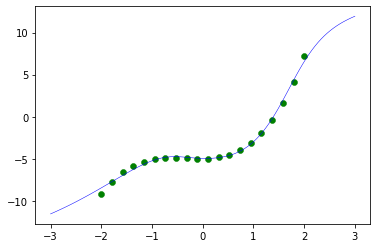

In [20]:
def mlp(params, inputs):
    # A multi-layer perceptron, i.e. a fully-connected neural network.
    for w, b in params:
        outputs = jnp.dot(inputs, w) + b  # Linear transform
        inputs = jnp.tanh(outputs)  # Nonlinearity
    return outputs


def resnet(params, inputs, depth):
    for i in range(depth):
        outputs = mlp(params, inputs) + inputs
    return outputs


resnet_depth = 3


def resnet_squared_loss(params, inputs, targets):
    preds = resnet(params, inputs, resnet_depth)
    return jnp.mean(jnp.sum((preds - targets)**2, axis=1))


def init_random_params(scale, layer_sizes):
    return [
        (
            scale * np.random.randn(m, n),  #
            scale * np.random.randn(n))  #
        for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])
    ]


# A simple gradient-descent optimizer.
@jax.jit
def resnet_update(params, inputs, targets):
    grads = jax.grad(resnet_squared_loss)(params, inputs, targets)
    return [
        (w - step_size * dw, b - step_size * db)  #
        for (w, b), (dw, db) in zip(params, grads)
    ]


# Toy 1D dataset.
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 20), (20, 1))
targets = inputs ** 3 + inputs ** 2 + 0.1 * inputs - 5

# Hyperparameters.
layer_sizes = [1, 20, 1]
param_scale = 1.0
step_size = 0.01
train_iters = 1000

# Initialize and train.
resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
    resnet_params = resnet_update(resnet_params, inputs, targets)

# Plot results.
ax = plt.subplot()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')

ODE 的训练，其实是把 ResNet 里的 $\mathrm{MLP}: \mathbb{R}^n \rightarrow \mathbb{R}^n$ 变成了 $\mathrm{MLP}: (\mathbb{R}^n, \mathbb{R}) \rightarrow \mathbb{R}^n$。

- ResNet 的 MLP 直接 formulate 了输出。

- ODE 的 MLP formulate 了不同时间段的导数 `f'`，借此建模了 hidden 的从输入 $x$ ($t=0$) 变到输出 $y$ ($t=1$)的 dynamics。

- ODE 代表 $x$ 的导数，随着时间变化，$x$ 会变，下一刻应该是 $x=x+\mathrm{MLP}(x, t) dx$，不能用 $\int_0^1 \mathrm{MLP}(x_0, t)$ 来作为最终的 $x$，而应该是：

$$
x(0) + \int_0^1 \mathrm{MLP}(x(t), t)
$$

allocating 1 rows x 2 cols for 2 subplots.


Text(0, 0.5, 'time / depth')

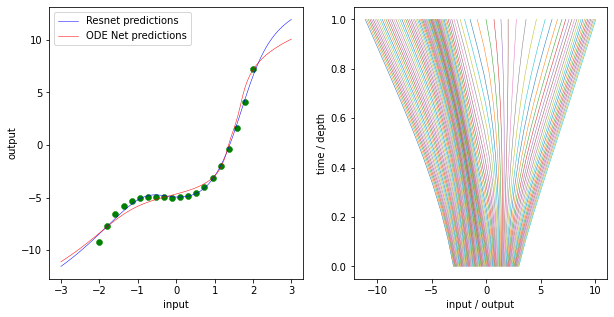

In [283]:
def nn_dynamics(state, time, params):
    state_and_time = jnp.hstack([state, jnp.array(time)])
    return mlp(params, state_and_time)


def odenet(params, input):
    start_and_end_times = jnp.array([0.0, 1.0])
    init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
    return final_state

batched_odenet = jax.vmap(odenet, in_axes=(None, 0))

# We need to change the input dimension to 2, to allow time-dependent dynamics.
odenet_layer_sizes = [2, 20, 1]


def odenet_loss(params, inputs, targets):
    preds = batched_odenet(params, inputs)
    return jnp.mean(jnp.sum((preds - targets)**2, axis=1))


@jax.jit
def odenet_update(params, inputs, targets):
    grads = jax.grad(odenet_loss)(params, inputs, targets)
    return [
        (w - step_size * dw, b - step_size * db)  #
        for (w, b), (dw, db) in zip(params, grads)
    ]


# Initialize and train ODE-Net.
odenet_params = init_random_params(param_scale, odenet_layer_sizes)

for i in range(train_iters):
    odenet_params = odenet_update(odenet_params, inputs, targets)

# Plot resulting model.
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))


layout = PlotLayout(plt, 2, num_per_row=2, row_width=5, col_width=5)
layout.prepare()
ax = layout.subplot(0)
ax.scatter(inputs, targets, lw=0.5, color='green')
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs), lw=0.5, color='red')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(('Resnet predictions', 'ODE Net predictions'))


@jax.jit
def odenet_times(params, input, times):
    def dynamics_func(state, time, params):
        return mlp(params, jnp.hstack([state, jnp.array(time)]))

    return odeint(dynamics_func, input, times, params)


times = jnp.linspace(0.0, 1.0, 10)

ax = layout.subplot(1)
for i in fine_inputs:
    ax.plot(odenet_times(odenet_params, i, times), times, lw=0.5)

ax.set_xlabel('input / output')
ax.set_ylabel('time / depth')

In [306]:
x0 = jnp.array([-3.0])
print(f"x0={x0}")

# 直接跑网络
nn0 = nn_dynamics(x0, jnp.array([0.0]), odenet_params)
nn1 = nn_dynamics(x0, jnp.array([1.0]), odenet_params)
print(f"ODE layer: nn0={nn0}, nn1={nn1}")


# 调用 odeint
int01 = odeint(nn_dynamics, x0, jnp.array([0.0, 1.0]), odenet_params)
print("odeint", int01[1])

# 错误的 ode：fix x0，直接对 t 积分
# \int_t (x0, t)|_0^t
bin = 0.0001
my_ode = x0 + vmap(nn_dynamics, in_axes=(0, 0, None))(
    jnp.ones([int(1/bin), 1]) * x0,  #
    jnp.arange(0.0, 1.0, bin).reshape(int(1/bin), 1),
    odenet_params
).sum() * bin
print("false", my_ode)

# 正确的 ode：t 变化会带来 x 的变化！
# x -> x'(t) -> update x
# ↑                    ↓
# ----------←-----------
x = jnp.array([-3.0])
for t in jnp.arange(0.0, 1.0, 0.001):
    x_dot = nn_dynamics(x, jnp.array([t]), odenet_params)
    x += x_dot * 0.001
print("true", x)

x0=[-3.]
ODE layer: nn0=[-4.091174], nn1=[-6.1493635]
odeint [-11.103082]
false [-7.987697]
true [-11.098608]
